# Introduction

## Dataset

[Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

This Online Retail data set contains all the transactions occurring for a UK-based and registered, non-store online retail between `01-Dec-2010` and `09-Dec-2011`.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Attribute Information:

- `InvoiceNo`: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- `StockCode`: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- `Description`: Product (item) name. Nominal.
- `Quantity`: The quantities of each product (item) per transaction. Numeric.
- `InvoiceDate`: Invoice date and time. Numeric. The day and time when a transaction was generated.
- `UnitPrice`: Unit price. Numeric. Product price per unit in sterling (£).
- `CustomerID`: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- `Country`: Country name. Nominal. The name of the country where a customer resides.

## RFM

**RFM** is commonly used to identify customers who are likely to buy more frequently, spend more, and/or are more likely to return to the company.

RFM stands for the three dimensions:
- `Recency` – How recently did the customer purchase?
- `Frequency` – How often do they purchase?
- `Monetary` – How much do they spend?

# Setup

In [1]:
# We'll use plotly-express to plot a treemap
!pip install --upgrade plotly
!pip install plotly-express

In [51]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# visualisation
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# to make subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# better matplotlib plots
%matplotlib inline
%config InlineBackend.figure_format="svg"

# Load data

In [35]:
data = pd.read_csv("../../data/OnlineRetail.csv", encoding="ISO-8859-1")
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset contains 541909 rows and 8 columns.


In [3]:
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
132150,547656,23004,TRAVEL CARD WALLET PANTRY,2,3/24/2011 12:53,0.42,13263.0,United Kingdom
315655,564733,23209,LUNCH BAG VINTAGE DOILY,5,8/28/2011 13:18,1.65,17841.0,United Kingdom
319684,564860,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,12,8/31/2011 10:06,1.25,17725.0,United Kingdom
130113,547412,22416,SET OF 36 DOILIES SPACEBOY DESIGN,12,3/23/2011 9:42,1.45,12399.0,Belgium
11588,537254,22112,CHOCOLATE HOT WATER BOTTLE,2,12/6/2010 11:01,4.95,15898.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
data.describe(include="object")

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


# EDA

Most of the customers in the dataset are from the UK

In [9]:
uk_percentage = data[data.Country == "United Kingdom"]["CustomerID"].nunique()/data["CustomerID"].nunique()
print(f"UK customers account for {uk_percentage*100:.2f}% of all customers")

UK customers account for 90.35% of all customers


In [16]:
df = data.groupby(["Country"])["CustomerID"].nunique().reset_index().sort_values(by=["CustomerID"], ascending=False)
fig = px.bar(
    df, x="Country", y="CustomerID", 
    height=600, width=600
)
fig.show()

In [24]:
cancelled_txn_percentage = 1 - (data[~data["InvoiceNo"].str.lower().str.contains("c")].shape[0]/data.shape[0])
print(f"{cancelled_txn_percentage*100:,.2f}% of transactions are cancelled transactions.")

1.71% of transactions are cancelled transactions.


# Data Preprocessing

Take 5 sample `InvoiceDate` from the dataset

In [26]:
data["InvoiceDate"].sample(5)

122321     3/17/2011 15:34
42636       1/4/2011 11:34
357045     9/23/2011 13:44
278476     7/25/2011 17:00
479840    11/18/2011 11:53
Name: InvoiceDate, dtype: object

We want to ensure that `InvoiceDate` is correctly of type `date`.

In addition, `CustomerID` should be of type `int`. Missing values will be ignored and kept as is. We'll handle them later.

In [36]:
data = data.assign(
    CustomerID=data["CustomerID"].astype(int, errors="ignore"),
    InvoiceDate=pd.to_datetime(data["InvoiceDate"], format="%m/%d/%Y %H:%M"),
)

InvoiceNo starting with 'c' indicates a cancellation. Thus, we want to remove these records from the dataset

In [37]:
print(f"Before: {data.shape[0]} rows and {data.shape[1]} columns.")
data = data[~data["InvoiceNo"].str.lower().str.contains("c")]
print(f"After : {data.shape[0]} rows and {data.shape[1]} columns.")

Before: 541909 rows and 8 columns.
After : 532621 rows and 8 columns.


There are many ways to deal with missing values in a data science project. We'll choose the simplest method here by dropping the records with missing values.

In [39]:
print(f"Before: {data.shape[0]} rows and {data.shape[1]} columns.")
data = data[~data["CustomerID"].isna()]
print(f"After : {data.shape[0]} rows and {data.shape[1]} columns.")

Before: 532621 rows and 8 columns.
After : 397924 rows and 8 columns.


By removing cancelled transactions and missing `CustomerID`, there are no longer any transactions with negative `Quantity`.

In [40]:
data[data["Quantity"] < 0].shape

(0, 8)

Verify that there are no longer any missing values in the dataset

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


# RFM Analysis

## Recency

**Recency**: How recently did the customer purchase?

In order to answer this question, we need to have an anchor date. We'll take the last `InvoiceDate` as the anchor date.

In [42]:
LAST_INVOICE_DATE = data["InvoiceDate"].max()
print(f"Anchor date: {LAST_INVOICE_DATE}")

Anchor date: 2011-12-09 12:50:00


Recency will be calculated as the number of days between the **anchor date** and the last `InvoiceDate` of each customer.
- Firstly, we need to find the last `InvoiceDate` of each customer.
- Secondly, we'll calculate the time difference between the **anchor date** and the last `InvoiceDate` of each customer. 

In [43]:
# find the last InvoiceDate for each customer
recency_data = data.groupby(["CustomerID"])["InvoiceDate"].agg(["min", "max"])
recency_data.rename(columns={"min": "FirstOrderDate", "max": "LastOrderDate"}, inplace=True)

# calculate the time difference between the anchor and the last InvoiceDate of each customer
recency_data["Recency"] = LAST_INVOICE_DATE - recency_data["LastOrderDate"]
recency_data["Recency"] = recency_data["Recency"].dt.days
recency_data.drop(columns=["FirstOrderDate", "LastOrderDate"], inplace=True)

In [44]:
# have a look at the recency, we just calculated
recency_data.head()

,Recency
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


In [46]:
print(f"Recency data contains {recency_data.shape[0]} customers (rows)")

Recency data contains 4339 customers (rows)


Let's take a look at the `recency` distribution

In [69]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Distribution", "Boxplot"),
    x_title="Number of days between the last transaction and the anchor date",
    y_title="Customer Count",
)

fig.add_trace(
    go.Histogram(x=recency_data["Recency"],),
    row=1, col=1,
)

fig.add_trace(
    go.Box(x=recency_data["Recency"],),
    row=1, col=2,
)


fig.update_layout(height=500, width=1000, showlegend=False, title_text="Recency")

In [50]:
fig = px.histogram(
    data_frame=recency_data, x="Recency",
    labels={"Recency": "Recency (days)"},
    height=400, width=600
)
fig.show()

## Frequency

In [21]:
# find the number of purchases made by each customer by counting the number of unique invoices
frequency_data = data.groupby(["CustomerID"])["InvoiceNo"].agg(["nunique"])
frequency_data.rename(columns={"nunique": "Frequency"}, inplace=True)
frequency_data.head()

,Frequency
CustomerID,
12346,1
12347,7
12348,4
12349,1
12350,1


In [22]:
frequency_data.shape

(4339, 1)

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

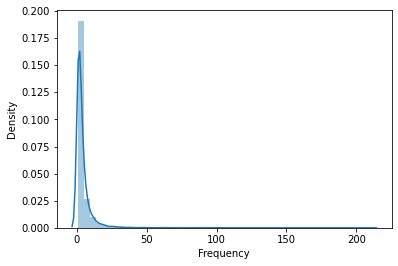

In [23]:
sns.distplot(frequency_data["Frequency"], kde=True)

## Monetary

In [24]:
# calculate monetary value of each purchase
data["Amount"] = data["UnitPrice"] * data["Quantity"]

# find the total amount spent for each customer
monetary_data = data.groupby(["CustomerID"])["Amount"].agg(["sum"])

monetary_data.rename(columns={"sum": "Monetary"}, inplace=True)
monetary_data.head()

,Monetary
CustomerID,
12346,77183.60
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


In [25]:
monetary_data.shape

(4339, 1)

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

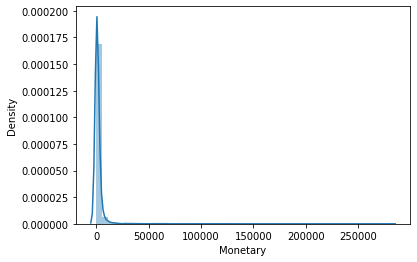

In [26]:
sns.distplot(monetary_data["Monetary"], kde=True)

## Combine RFM

In [27]:
rfm_data = pd.concat([recency_data, frequency_data, monetary_data], axis=1)
rfm_data.reset_index(inplace=True)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


In [28]:
rfm_data.shape

(4339, 4)

# RFM Score

In [29]:
# RFM scores are defined such that score of 5 and 1 are the best and the worst respectively
# most recent purchase should receive the highest score
rfm_data["RScore"] = pd.qcut(rfm_data["Recency"], 5, labels=range(5, 0, -1))

# the more purchases a customer has made, the higher the score
# Some customers will have the same number of purchases, so we'll rank the frequency score based on the first appearance
rfm_data["FScore"] = pd.qcut(rfm_data["Frequency"].rank(method="first"), 5, labels=range(1, 6, 1))

# the more money a customer has spent, the higher the score
rfm_data["MScore"] = pd.qcut(rfm_data["Monetary"], 5, labels=range(1, 6, 1))

In [30]:
rfm_data["RFMScore"] = (
    rfm_data["RScore"].astype(str) 
    + rfm_data["FScore"].astype(str) 
    + rfm_data["MScore"].astype(str)
)

rfm_data["RFMTotal"] = (
    rfm_data["RScore"].astype(int) 
    + rfm_data["FScore"].astype(int) 
    + rfm_data["MScore"].astype(int)
)

In [31]:
# best customers
rfm_data[rfm_data["RFMScore"] == "555"].head()

,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore,RFMTotal
1,12347,1,7,4310.00,5,5,5,555,15
15,12362,2,10,5226.23,5,5,5,555,15
56,12417,2,9,3649.10,5,5,5,555,15
71,12433,0,7,13375.87,5,5,5,555,15
75,12437,1,18,4951.41,5,5,5,555,15


In [32]:
# worst customers
rfm_data[rfm_data["RFMScore"] == "111"].head()

,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore,RFMTotal
6,12353,203,1,89.00,1,1,1,111,3
14,12361,286,1,189.90,1,1,1,111,3
43,12401,302,1,84.30,1,1,1,111,3
44,12402,322,1,225.60,1,1,1,111,3
77,12441,366,1,173.55,1,1,1,111,3


# Segmentation with RFM

Refer to [Putlet_RFM_Analysis](https://www.putler.com/rfm-analysis/) for more details.

|No|Customer Segment|Activity|Actionable Tip|
|:-:|:-|:-|:-|
|1|**Champions**|Bought recently, buy often and spend the most!|Reward them. Can be early adopters for new products. Will promote your brand.|
|2|**Loyal Customers**|Spend good money with us often. Responsive to promotions.|Upsell higher value products. Ask for reviews. Engage them.|
|3|**Potential Loyalist**|Recent customers, but spent a good amount and bought more than once.|Offer membership / loyalty program, recommend other products.|
|4|**New Customers**|Bought most recently, but not often.|Provide on-boarding support, give them early success, start building relationship.|
|5|**Promising**|Recent shoppers, but haven’t spent much.|Create brand awareness, offer free trials|
|6|**Need Attention**|Above average recency, frequency and monetary values. May not have bought very recently though.|Make limited time offers, Recommend based on past purchases. Reactivate them.|
|7|**About To Sleep**|Below average recency, frequency and monetary values. Will lose them if not reactivated.|Share valuable resources, recommend popular products / renewals at discount, reconnect with them.|
|8|**At Risk**|Spent big money and purchased often. But long time ago. Need to bring them back!|Send personalized emails to reconnect, offer renewals, provide helpful resources.|
|9|**Can’t Lose Them**|Made biggest purchases, and often. But haven’t returned for a long time.|Win them back via renewals or newer products, don’t lose them to competition, talk to them.|
|10|**Hibernating**|Last purchase was long back, low spenders and low number of orders.|Offer other relevant products and special discounts. Recreate brand value.
|11|**Lost**|Lowest recency, frequency and monetary scores.|Revive interest with reach out campaign, ignore otherwise.|

In [33]:
# segmentation map based on Recency and Average of Frequency-Monetary Score
segmentation_map = {
    r'[1-2][1-2]': "Hibernating",
    r'[1-2][3-4]': "At Risk",
    r'[1-2]5': "Can\'t Loose",
    r'3[1-2]': "About to Sleep",
    r'33': "Need Attention",
    r'[3-4][4-5]': "Loyal Customers",
    r'41': "Promising",
    r'51': "New Customers",
    r'[4-5][2-3]': "Potential Loyalists",
    r'5[4-5]': "Champions"
}

In [34]:
rfm_data["Segment"] = rfm_data[["FScore", "MScore"]].mean(axis=1).round().astype(int)
rfm_data["Segment"] = rfm_data["RScore"].astype(str) + rfm_data["Segment"].astype(str)
rfm_data["Segment"] = rfm_data["Segment"].replace(segmentation_map, regex=True)

In [35]:
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore,RFMTotal,Segment
0,12346,325,1,77183.60,1,1,5,115,7,At Risk
1,12347,1,7,4310.00,5,5,5,555,15,Champions
2,12348,74,4,1797.24,2,4,4,244,10,At Risk
3,12349,18,1,1757.55,4,1,4,414,9,Potential Loyalists
4,12350,309,1,334.40,1,1,2,112,4,Hibernating


In [36]:
rfm_data.groupby(["Segment"])[
    "Recency",
    "Frequency",
    "Monetary"
].agg(["median", "mean", "count"]).reset_index()

Segment Recency                   Frequency                   \
                        median        mean count    median       mean count   
0       About to Sleep    52.0   52.169192   396       1.0   1.325758   396   
1              At Risk   126.0  145.361616   495       3.0   3.195960   495   
2          Can't Loose   108.0  132.060606    33       8.0   9.696970    33   
3            Champions     4.0    4.905344   655       7.0  12.061069   655   
4          Hibernating   214.0  213.830508  1180       1.0   1.238136  1180   
5      Loyal Customers    29.0   32.964523   902       5.0   6.111973   902   
6       Need Attention    51.5   53.372549   102       2.0   2.254902   102   
7        New Customers     6.0    5.650000    20       1.0   1.000000    20   
8  Potential Loyalists    17.0   16.112000   500       2.0   1.858000   500   
9            Promising    21.5   22.267857    56       1.0   1.000000    56   

   Monetary                     
     median         mean count  
0   309.780   354.809798   396  
1  1013.040  1601.216590   495  
2  3450.840  4226.443030    33  
3  2567.060  6968.202641   655  
4   283.025   328.699399  1180  
5  1740.540  2825.459802   902  
6   709.335   819.300686   102  
7   184.395   184.807000    20  
8   406.235   485.497580   500  
9   150.165   146.643393    56

# Visualisation

In [37]:
df = rfm_data["Segment"].value_counts().reset_index()
df.columns = ["Segment", "Count"]
fig = px.treemap(df, path=["Segment"], values="Count", width=800, height=400)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

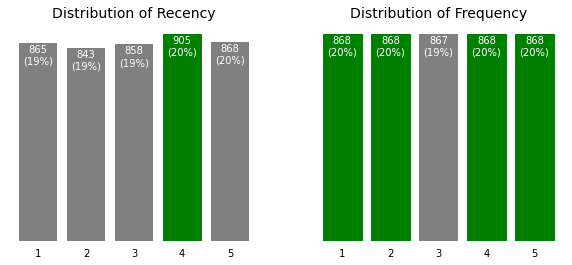

In [38]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['RScore', 'FScore']):
    parameters = {'RScore':'Recency', 'FScore':'Frequency'}
    y = rfm_data[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='grey')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('green')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

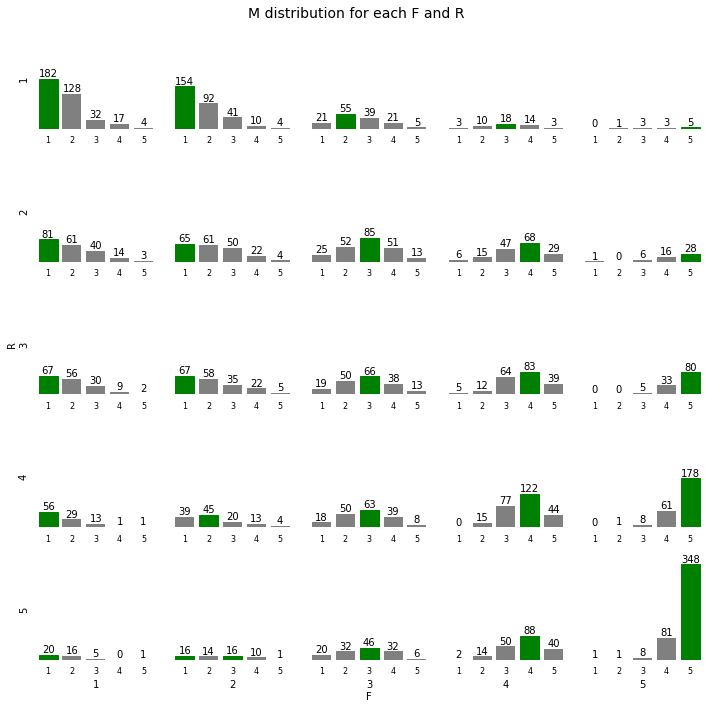

In [39]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

for r in range(1, 6):
    for f in range(1, 6):
        y = rfm_data[(rfm_data["RScore"] == r) & (rfm_data["FScore"] == f)]["MScore"].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color="grey")
        if r == 5:
            if f == 3:
                ax.set_xlabel(f"{f}\nF", va='top')
            else:
                ax.set_xlabel(f"{f}\n", va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel(f"R\n{r}")
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color("green")
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha="center",
                    va="bottom",
                    color="k")
fig.suptitle("M distribution for each F and R", fontsize=14)
plt.tight_layout()
plt.show()